# Part 1. K-means
In this part, we will study two mechanisms to find the best K value in K-means:
- Elbow method
- Silouette

For this, we will work with the Iris dataset, assuming we do not know the labels.

Let's start by loading the dataset and inspecting it.

In [2]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

import utils

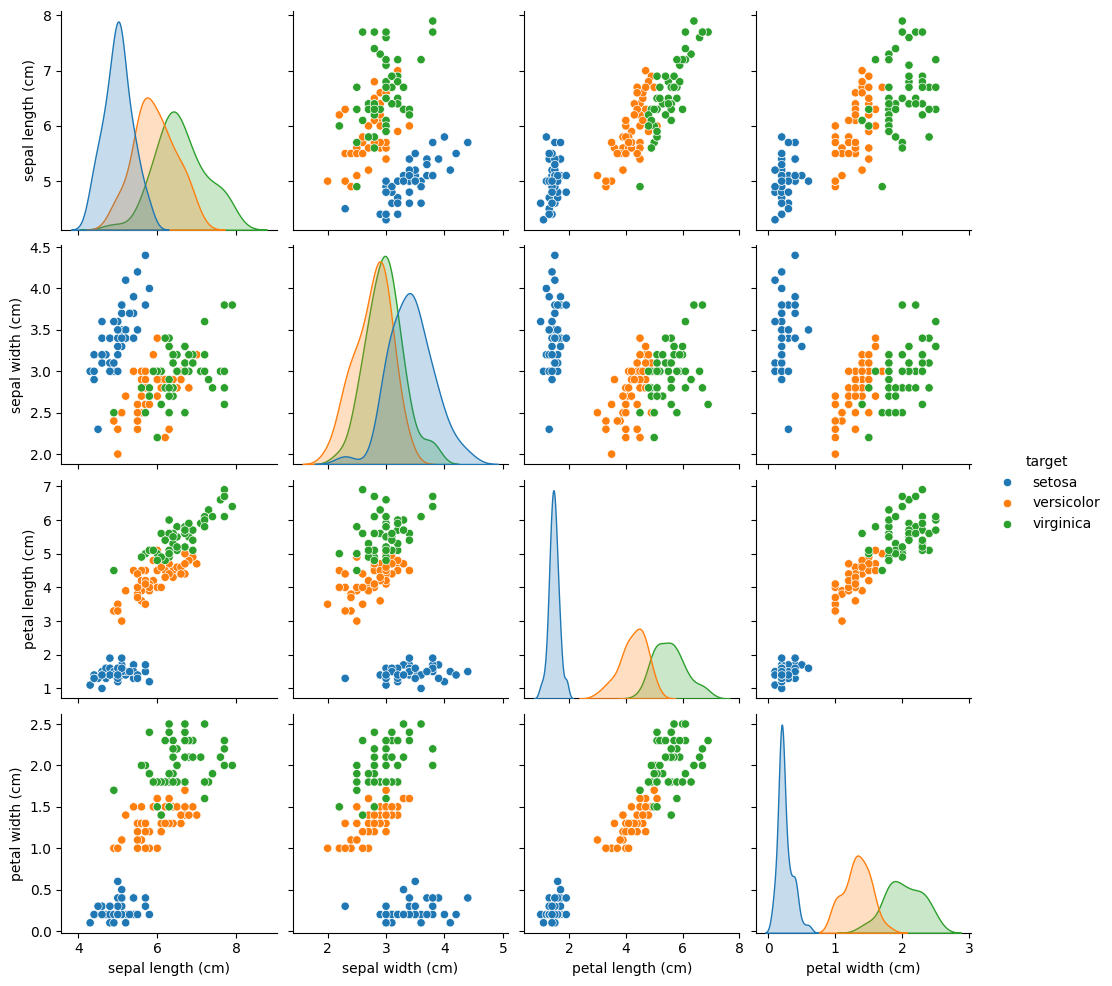

In [3]:
iris = load_iris(as_frame=True)

# Rename classes using the iris target names
iris.frame["target"] = iris.target_names[iris.target]
_ = sns.pairplot(iris.frame, hue="target")

**Question 1:** Based on your inspection of the data, which pairset of features seems to best cluster the data? Which pairset seems to be the worst?

**Best clustering pairset:**
The pair of features "petal length (cm)" and "petal width (cm)" shows the best clustering. The three species (setosa, versicolor, and virginica) are well-separated in this plot, especially with setosa forming a distinct cluster and virginica and versicolor separating along different axes.

**Worst clustering pairset:**
The pair of features "sepal length (cm)" and "sepal width (cm)" shows the worst clustering. There is significant overlap between the species, making it difficult to distinguish them based on these features alone.

You will be using the pair of features identified as the features best reflecting the clusters in the data for most of the remaining plots in this notebook. Please the set dim_1 and dim_2 variables in the cell below, according to you answer in *Question 1* and considering the following indices:

- sepal length : 0
- sepal width : 1
- petal length : 2
- petal width : 3

In [7]:
dim_1 = 2  # petal length
dim_2 = 3  # petal width

## The Elbow method

The Elbow Method is a heuristic used in unsupervised machine learning to determine the optimal number of clusters in a dataset.

**The Algorithm for K-means:**

1. Run K-means for different values of K.
2. Compute the Within-Cluster Sum of Squares (WCSS) for each K.
\begin{equation}
WCSS = \sum_{k=1}^{K} \sum_{x \in C_k} ||x - \mu_k||^2
\end{equation}
where $K$ denotes the number of clusters, $C_k$ is the set of points in the $k^{th}$ cluster, and $\mu_k$ its prototype vector.

3. Plot WCSS vs K values.
4. Identify the "elbow" point: The plot will typically show a sharp decrease in WCSS as K increases initially. At some point, the rate of decrease slows down, and the curve forms an "elbow." This elbow point often indicates the optimal value of K.

### Task 1.

Implement steps 1 and 2 of elbow method to choose the best K for K-means when dealing with the Iris dataset.

Your implementation needs to comply to the following requirements:
1. You normalize the data to have mean zero and standard deviation 1.
2. Usage of scikit-learn K-means to cluster the data.
3. **Your own implementation** to compute the WCSS. **You cannot use scikit-learn built-in functions**.
4. The estimated WCSS per each K needs to be stored in a vector.
5. Your results need to be compatible with the plot_elbow function provided in the utils.py file. This function will plot for you the elbow curve. The function's arguments are:
  - the maximum value of K to test
  - a vector containing the estimated K WCSS values.
6. Test for K from 1 to 10.

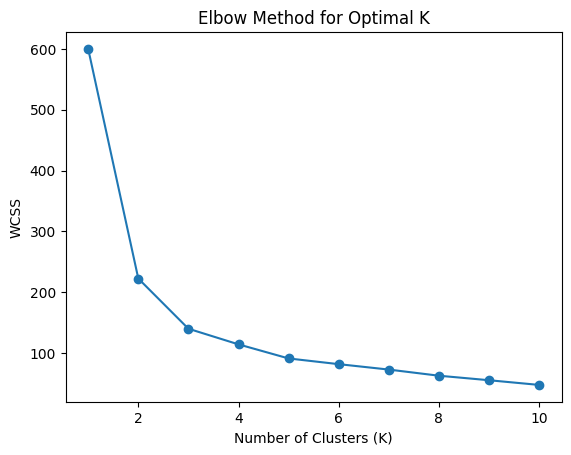

In [4]:
# Extract feature data
X = iris.data

# Normalize the data to have mean zero and standard deviation 1
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Function to compute WCSS
def compute_wcss(X, labels, centroids):
    wcss = 0
    for i, centroid in enumerate(centroids):
        cluster_points = X[labels == i]
        wcss += np.sum((cluster_points - centroid) ** 2)
    return wcss

# Variables
K = 10
wcss = []

# Loop through values of K and compute WCSS
for k in range(1, K + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Use K-means
    kmeans.fit(X_normalized)

    # Compute WCSS manually
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    wcss_k = compute_wcss(X_normalized, labels, centroids)
    wcss.append(wcss_k)

# Plot the elbow curve using the provided function
utils.plot_elbow(K, wcss)


**Question 2**: What value of K did you choose? Is it compatible with what you know about the "true" labels in the iris dataset? Justify your answer.


**Value of K chosen:**
Based on the Elbow Method, the optimal value of K is the "elbow point" in the plot of WCSS in function of K. For the Iris dataset:

The "elbow" is observed at K=3 because the reduction in WCSS slows significantly after this point.

**Compatibility with "true" labels:**
The choice of K=3 is compatible with the true labels in the Iris dataset because:

The Iris dataset has three distinct classes: setosa, versicolor, and virginica.
When visualizing feature relationships (like in the pairplot or scatterplots), there are clear separations between three clusters for features such as petal length and petal width.

K=3 aligns with the biological reality of the dataset, as it contains samples from three distinct species.

**Task 2.** Create two plots: one showing your clustering results (your chosen K) and another one displaying the true labels. Use the two features you identified in *Question 1* as the two axis in your plot.

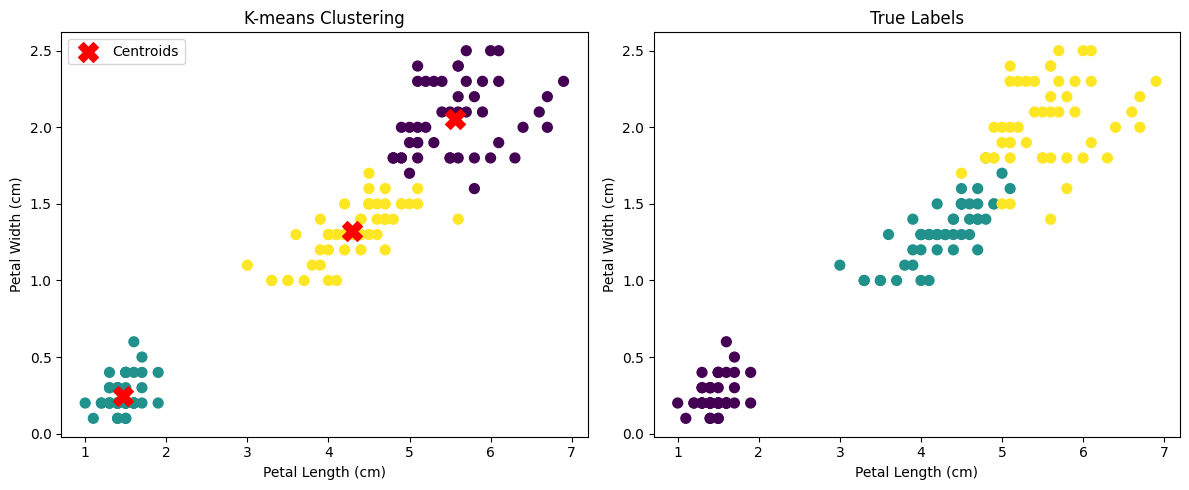

In [5]:
# Extract feature data and target labels
X = iris.data.iloc[:, [2, 3]].values  # Use petal length and petal width
y_true = iris.target

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Perform K-means clustering with the chosen K
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_normalized)

# Plot clustering results
plt.figure(figsize=(12, 5))

# Clustering results
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0] * scaler.scale_[0] + scaler.mean_[0],
            kmeans.cluster_centers_[:, 1] * scaler.scale_[1] + scaler.mean_[1],
            c='red', marker='X', s=200, label='Centroids')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('K-means Clustering')
plt.legend()

# True labels
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', s=50)
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('True Labels')

# Show the plots
plt.tight_layout()
plt.show()

## The Silouhette method
Silhouette is a method to interpret the consistency of clustered of data. It measures measures how similar a point is to its own cluster compared to other clusters. Moreover, it provides a graphical representation of how well each sample has been classified. Let's have a look at how it is computed.

For a point $x \in C_k$,
\begin{equation}
a(x) = \dfrac{1}{|C_k| -1}\sum_{z \in C_k, z \neq x} d(x,z),
\end{equation}
represents the mean distance $d()$ between $x$ and all other data points in the same cluster $C_k$, with $|\cdot|$ denoting the cardinality operator.

Let us now define

\begin{equation}
b(x) = \min_{j\neq k} \dfrac{1}{|C_j|}\sum_{z_\in C_j} d(x,z),
\end{equation}

which represents the smallest mean distance between $x$ and all points in other clusters, i.e. $z \notin C_k$. The cluster with the smallest mean distance is considered to be the neighboring cluster of $C_k, x \in C_k$.

For a given $x$,  its silouhette value is defined as:

$ s(x)= \left \lbrace \begin{array}{ll} 1 - a(x)/b(x)& \text{if } a(x) < b(x) \\ 0 & \text{if } a(x) = b(x) \\ b(x)/a(x) - 1 &  \text{if } a(x) > b(x) \end{array} \right.$

**The Silhouette scores**

The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
- a score close to 1 means that the data  the sample is far away from the neighboring clusters. Good clustering
- a score close to -1 meand that $x$ might have been assigned to the wrong cluster
- a score of 0 means that $x$ is on or very close to the decision boundary between two neighboring clusters.

For the full dataset, we consider the average across all points.

### Task 3
The code below runs K-means for 10 clusters, estimates the average silouhette score and generates the Silouhette plots.
Inspect the code and then run it.

For K = 2 The average silhouette_score is : 0.5817500491982808
For K = 3 The average silhouette_score is : 0.4798814508199818
For K = 4 The average silhouette_score is : 0.3850454053045392
For K = 5 The average silhouette_score is : 0.34503345350274617
For K = 6 The average silhouette_score is : 0.33394323040061763
For K = 7 The average silhouette_score is : 0.2664290993719981
For K = 8 The average silhouette_score is : 0.34162906041313373
For K = 9 The average silhouette_score is : 0.3243991438983545
For K = 10 The average silhouette_score is : 0.33540615043919825


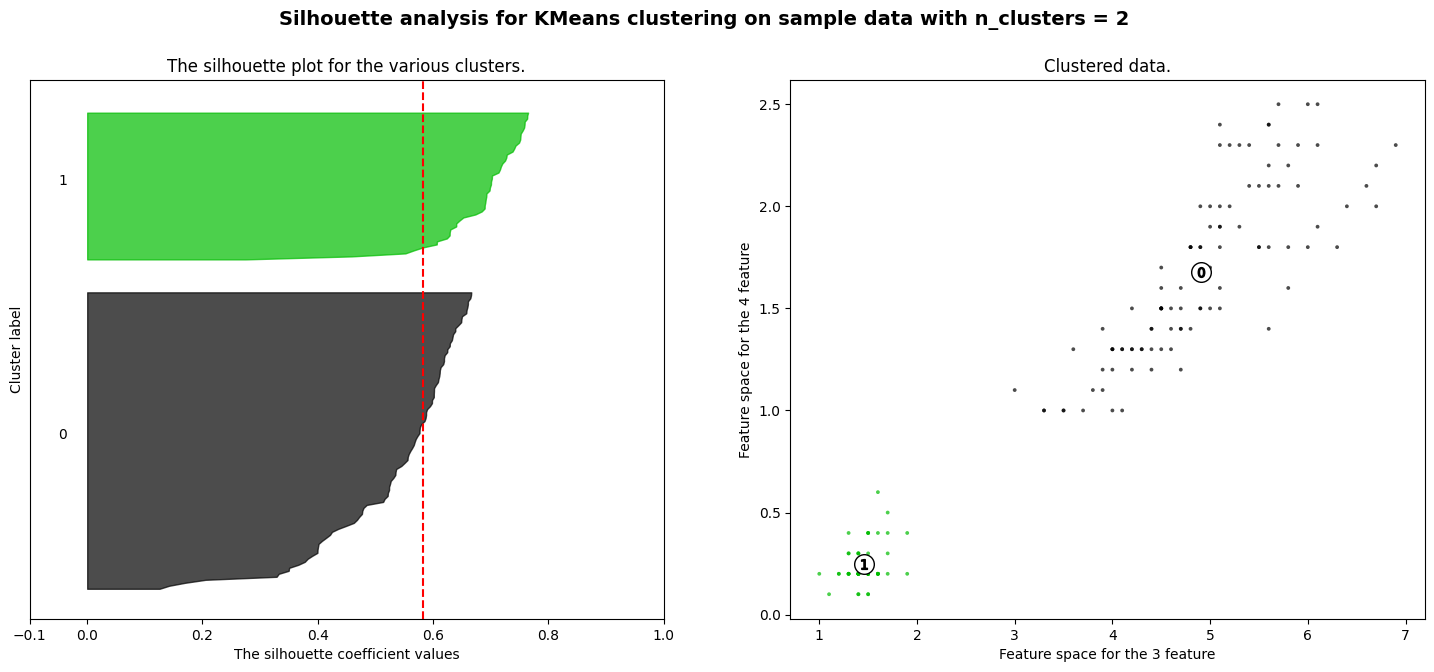

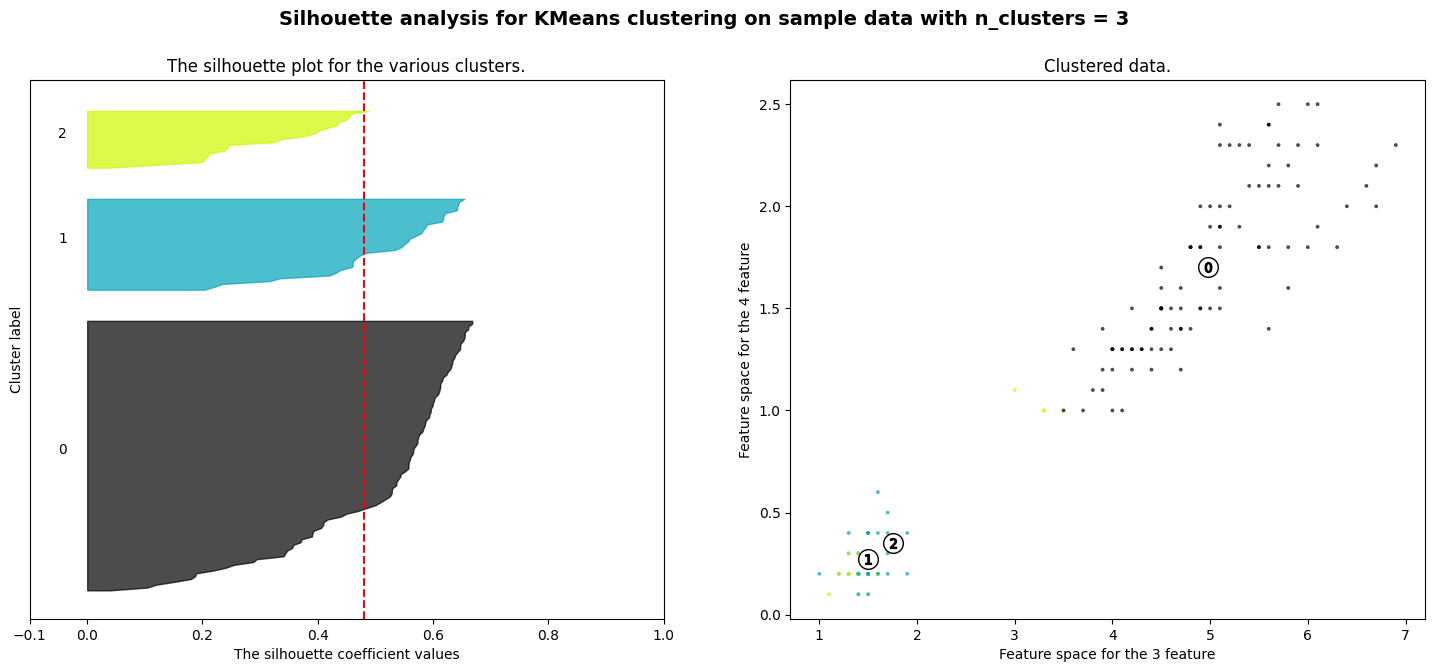

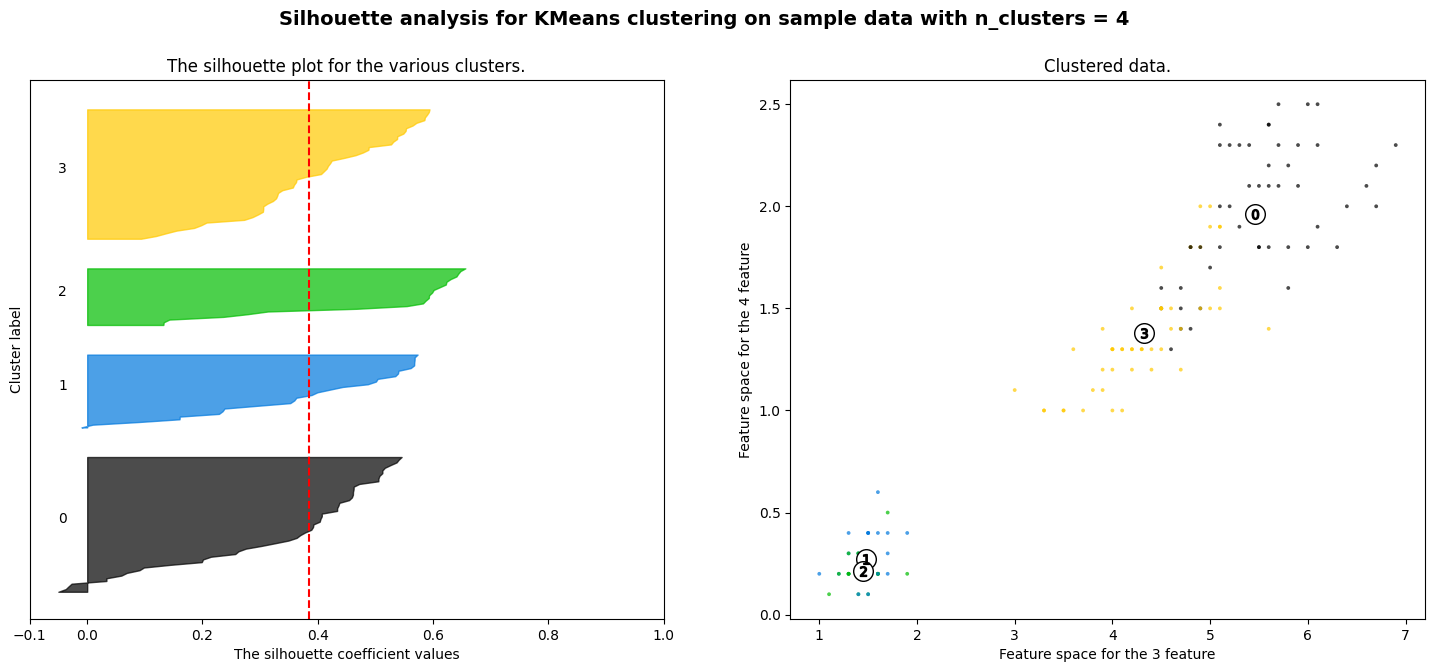

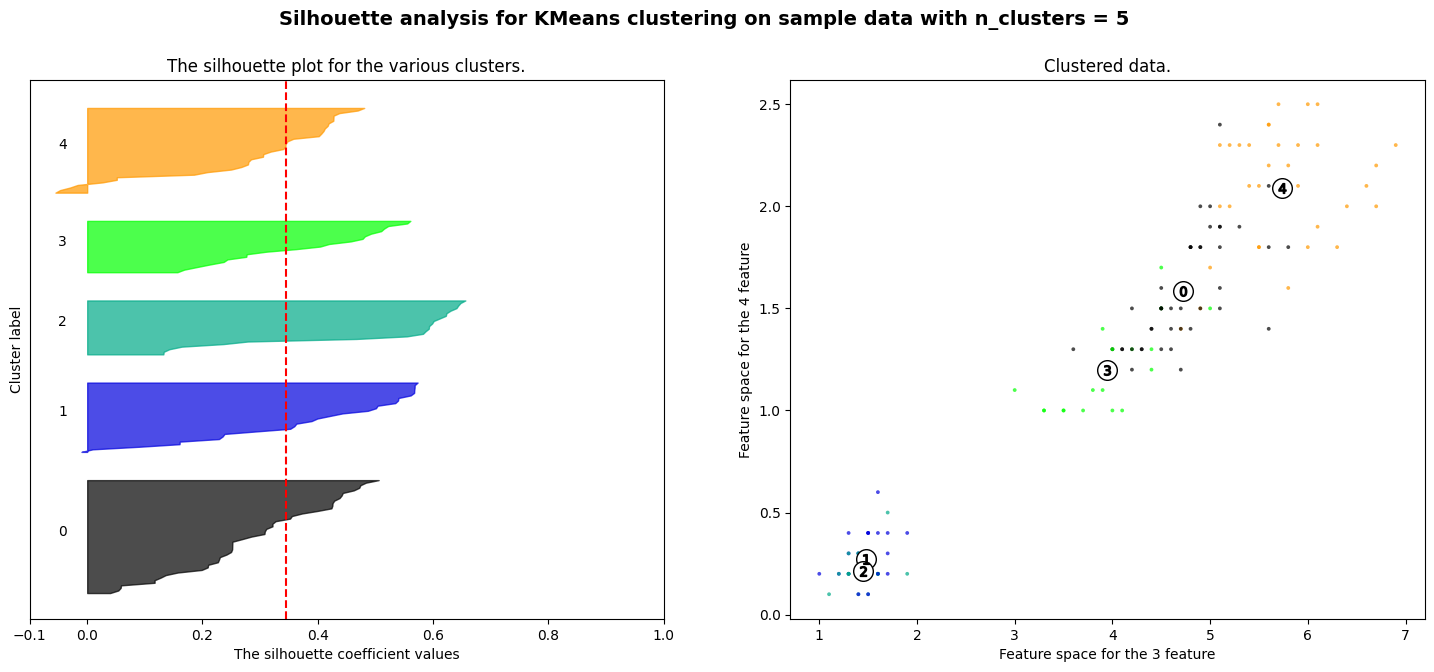

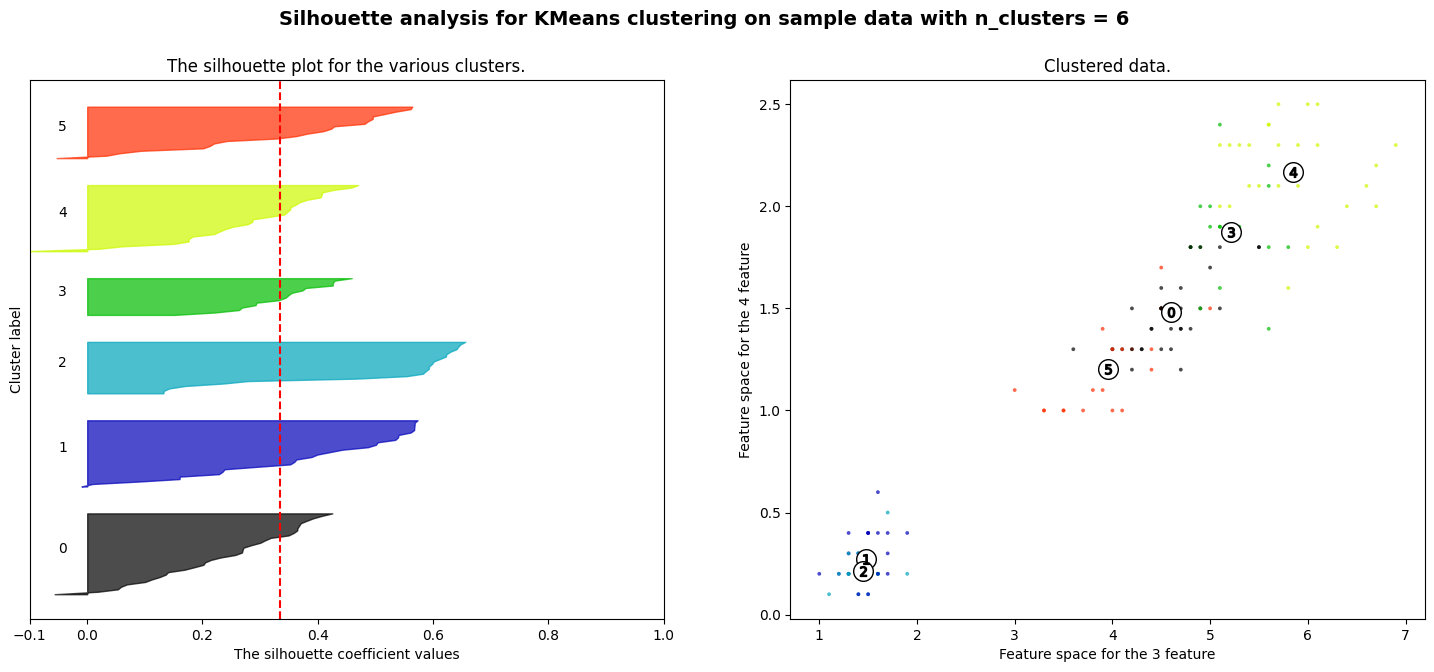

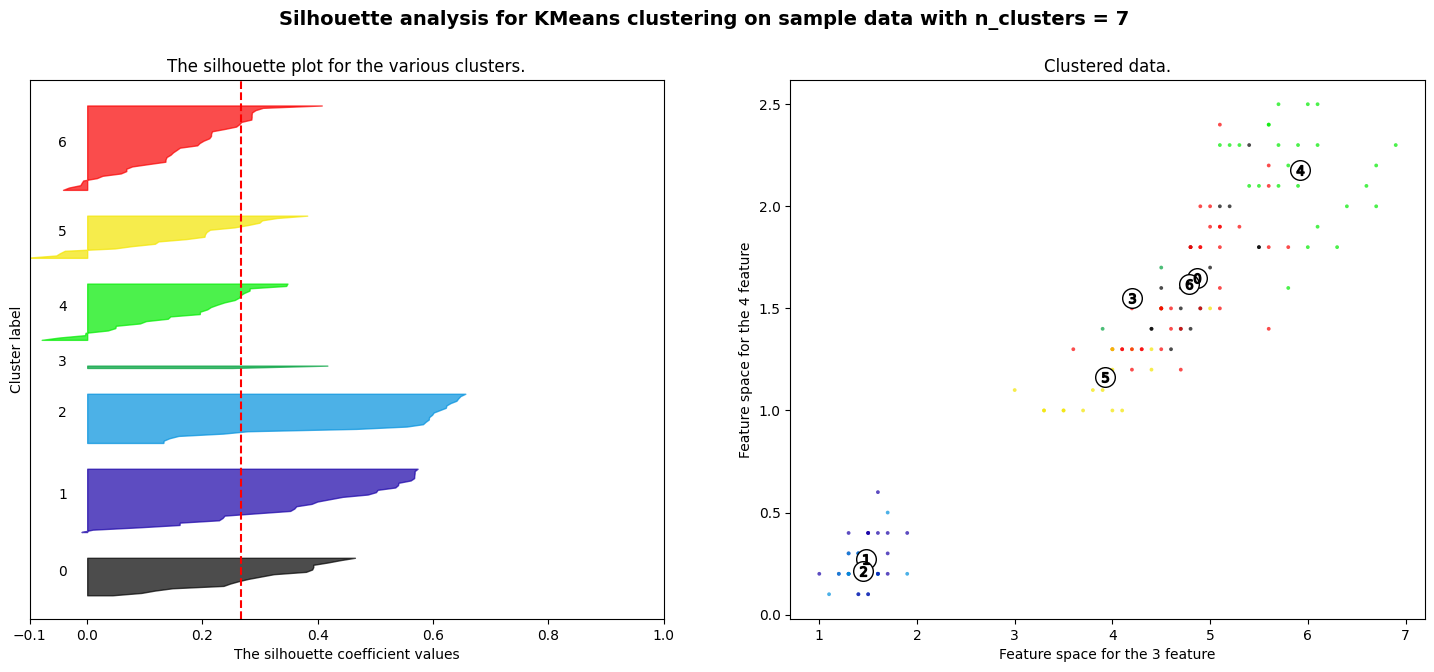

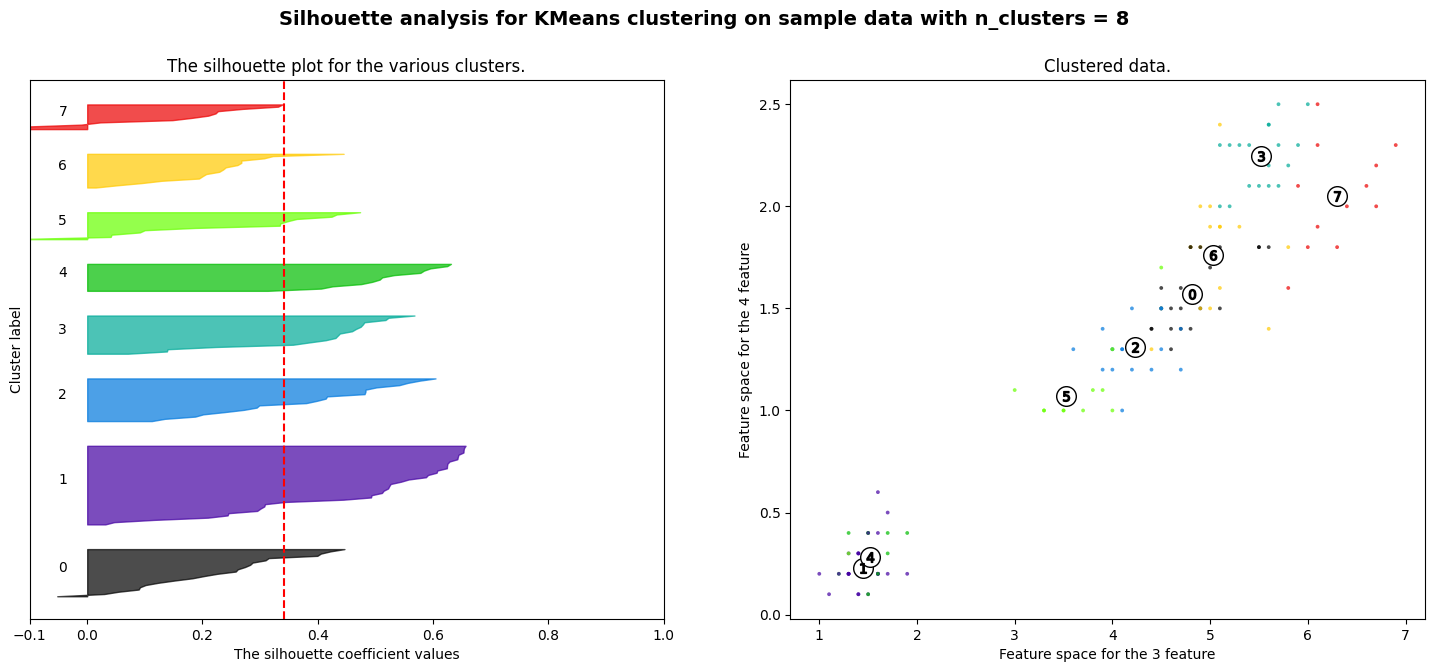

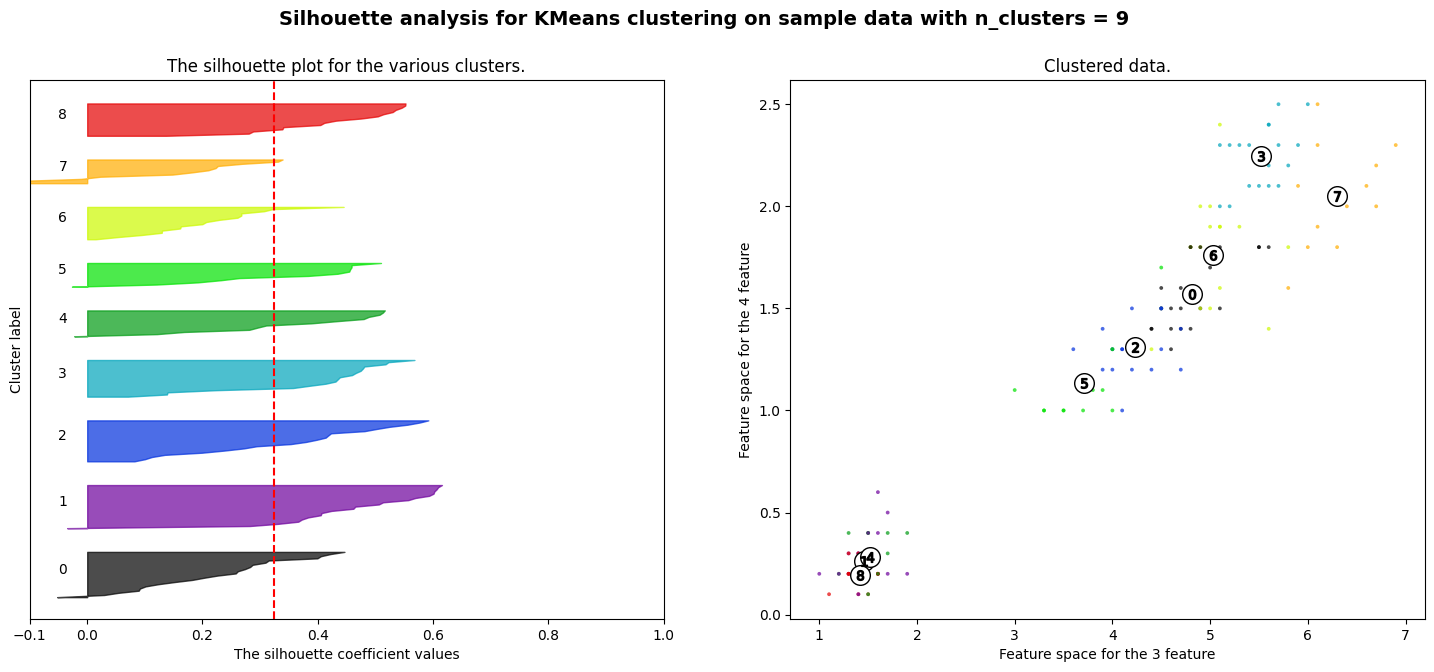

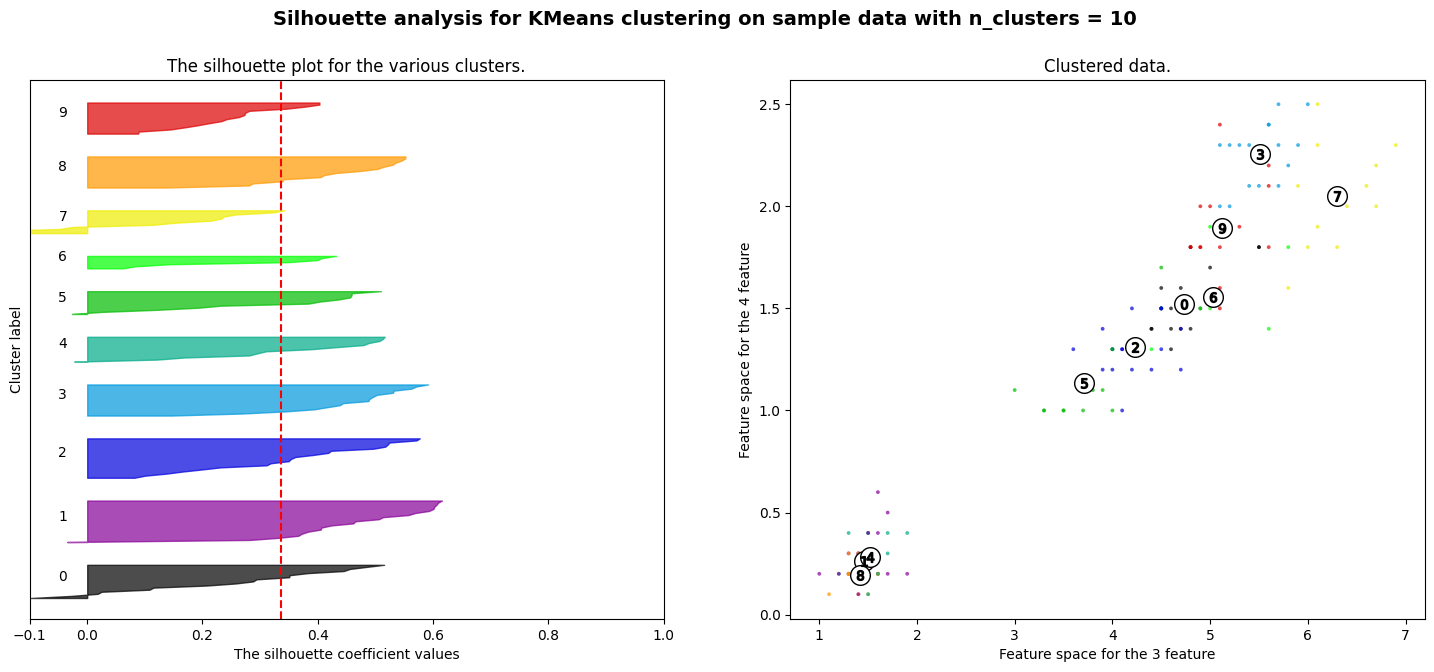

In [8]:
## Code adapted from scikit-learn

scaler = StandardScaler()
scaler.fit(iris.data)
normalized_data = scaler.transform(iris.data)
X_norm = normalized_data
X = iris.data.to_numpy()


for n_clusters in range(2, K+1):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_norm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_norm, cluster_labels)
    print(
        "For K =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, dim_1], X[:, dim_2], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = scaler.inverse_transform(clusterer.cluster_centers_)

    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, dim_1],
        centers[:, dim_2],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[dim_1], c[dim_2], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Clustered data.")
    ax2.set_xlabel("Feature space for the " + str(dim_1+1) + " feature")
    ax2.set_ylabel("Feature space for the " + str(dim_2+1) + " feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

**Question 3**. Based on the obtained results, which value of K you will use. Justify your answer in the light of the theory behind the Silhuette analysis


Based on silhouette analysis, K = 2 is the best choice as it has the highest average silhouette score (0.582), indicating well-defined and separated clusters. This aligns with the natural distinction between Iris-setosa and the other two species, though K=3 aligns with the true labels. Lower scores for K≥3 reflect overlapping clusters, particularly between Iris-versicolor and Iris-virginica.

**Question 4**. Are your result consistent with the elbow method? Are your results consistent with the true labels? Justify and motivate your answers.

**Consistency with the Elbow Method:**

Yes, the results are consistent with the elbow method. The elbow plot suggested
K=2 or K=3 as possible choices, with K=2 being optimal due to the sharpest reduction in WCSS. This matches the silhouette analysis, which also identifies
K=2 as the best-defined clustering.

**Consistency with True Labels:**

The results are partially consistent with the true labels. The true labels have
K=3, corresponding to the three Iris species. However, both the elbow and silhouette methods highlight the difficulty in clearly separating Iris-versicolor and Iris-virginica, which overlap in feature space. As a result, K=2 better reflects the structure in the dataset based on clustering metrics.